<class 'list'>
entering main section
Slice location...: 42
Slice location...: 47
Slice location...: 52
Slice location...: 57
Slice location...: 62
Slice location...: 67
Slice location...: 72
Slice location...: 77
Slice location...: 82
Slice location...: 87
Slice location...: 92
Slice location...: 97
Slice location...: 102
Slice location...: 107
Slice location...: 112
Slice location...: 117
Slice location...: 122
Slice location...: 127
Slice location...: 132
Slice location...: 137
Slice location...: 142
Slice location...: 147
Slice location...: 152
Slice location...: 157
Slice location...: 162
Slice location...: 167
Slice location...: 172
Slice location...: 177
Slice location...: 182
Slice location...: 187
Slice location...: 192
Slice location...: 197
Slice location...: 202
Slice location...: 207
Slice location...: 212
Slice location...: 217
Slice location...: 222
Slice location...: 227
Slice location...: 232
Slice location...: 237
Slice location...: 242
Slice location...: 247
Slice loc

NameError: name 'fail' is not defined

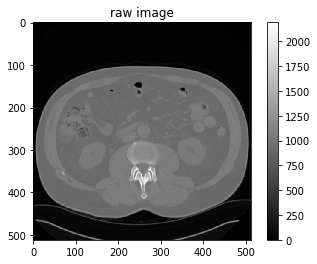

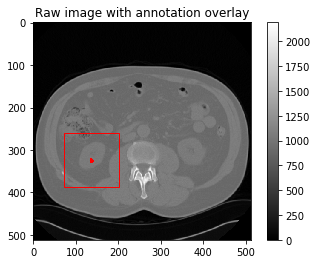

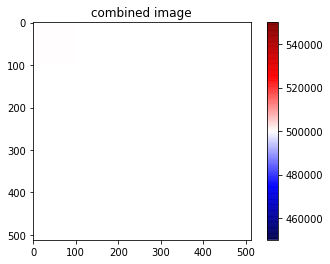

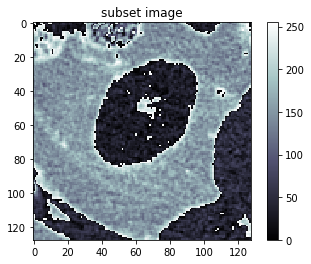

In [140]:
'''
Sample code to read dicom images and place slices as images for deep learning
'''
import matplotlib.pyplot as plt
import matplotlib.patches as patches  #subplot bounding boxes
from matplotlib.patches import Rectangle
import numpy as np
import os
import pydicom
from PIL import Image #for RGB manipulation


#MHA support files
import SimpleITK as sitk  #for reading the MHA files
from medpy.io import load #for mha files
import pickle

from copy import copy


def read_MHA(mha_full_path,mha_key):

    #####################################################
    #look for the MHA file. This will detail the 
    #segmented pixels for our label. The .mha files are 
    #stored above the \images folder
    ####################################################
    files_found = os.listdir(os.path.join(mha_full_path[mha_key], '..'))
    full_mha_file =''
    mha_found =0;
    for top_level_file in files_found:
        if top_level_file.endswith('.mha'):
            mha_name = top_level_file
            full_mha_file = os.path.join(mha_full_path[mha_key], '..', mha_name)
    if (full_mha_file == ''):
        print('!!!!! No MHA file found !!!!! @ ',mha_full_path[mha_key])
        mha_array=[]
    else:
        mha_array =get_mha_info(full_mha_file)
        mha_found = 1 #flag that we can use this later
    
    return mha_array, mha_found
    
    
    #open the mha file
    #itkimage = sitk.ReadImage(mha_full_file_path)
    #convert itkimage to 3D array
    #mha_data = sitk.GetArrayFromImage(itkimage)
    # the code below is for write the 3D array to a output file
    #return mha_data


def get_mha_info(mha_full_file_path):
    #open the mha file
    itkimage = sitk.ReadImage(mha_full_file_path)
    #convert itkimage to 3D array
    mha_data = sitk.GetArrayFromImage(itkimage)
    # the code below is for write the 3D array to a output file
    return mha_data 
    
    
    
def get_folders(partial_patient_directory,folder_dictionary,folder_key):
    print('----> folder_dictionary[fk][2] ', folder_dictionary[folder_key][2])
    full_name = os.path.join(partial_patient_directory, 
                             folder_dictionary[folder_key][2], 
                             'images')
    #full_name = os.path.join(top_data_dir,
    #                     clear_cell_dict[image1][3],
    #                     'images',
    #                     image1) #key, usually the patient folder
    print(full_name)
    return full_name

def make_images():
    for ii in range(0,len(position)-1):
    #slice = list(newpos.keys())[ii]
    #print(slice)
    #a = next(iter(newpos.values()))
    #print(a)
    
        slice = list(newpos.keys())[ii-1]
        print(slice)
        print(newpos[slice])
        full_file_r = os.path.join(dicom_dir, slice)
        slice = list(newpos.keys())[ii]
        full_file_g = os.path.join(dicom_dir, slice)
        slice = list(newpos.keys())[ii+1]
        full_file_b = os.path.join(dicom_dir, slice)

        #dicom_data_r = pydicom.dcmread(full_file_r)
        #dicom_data_g = pydicom.dcmread(full_file_g)
        #dicom_data_b = pydicom.dcmread(full_file_b)


        dicom_data_r = pydicom.dcmread(full_file_r)
        dicom_data_g = pydicom.dcmread(full_file_r)
        dicom_data_b = pydicom.dcmread(full_file_r)

        #(dicom_data.PixelData)
        #full_file = os.join(dicom_dir,ii)
        #dicom_data = pydicom.dcmread(full_file)
        # r, g, and b are 512x512 float arrays with values >= 0 and < 1.
        rgbArray = np.zeros((cols,rows,3), 'uint8')
        print(len(dicom_data_g.PixelData))

        #sample display of image
        #plt.figure()
        #plt.imshow(dicom_data_r.pixel_array,cmap='gray')

        rgbArray[:,:, 0] = dicom_data_r.pixel_array
        rgbArray[:,:, 1] = dicom_data_g.pixel_array
        rgbArray[..., 2] = dicom_data_b.pixel_array
        img = Image.fromarray(rgbArray)


        #setup an image subdirectory for each patient. The patient folder
        #is stored under the patient_directory list
        #output_image_dir is the main folder to store images, but must have folder for each 
        #patient created
        patient_image_folder = os.path.join(output_image_dir,phase_name,patient_directories[0])
        rgb_file = os.path.join(output_image_dir, 'rgb' + str(ii) + '.png')
        print('rgb file is ',rgb_file)
        img.save(rgb_file)

        #position[ii]


###########################################################################
# Dicom top level for RCC data. We will need to drill down into this to get the individual patient records
# The directory structure is the default given in the requested data set. rcc_use will toggle between
# processing data under clear cell directories or under oncocytoma directories
rcc_use = 1
if (rcc_use ==0):
    top_data_dir = '/media/kgonzalez/Seagate Backup Plus Drive/Heidi/clear_cell_onco/clear_cell'
    output_image_dir = '/media/kgonzalez/Seagate Backup Plus Drive/PROJECT_PLOTS/RCC'
else:
    top_data_dir = '/media/kgonzalez/Seagate Backup Plus Drive/Heidi/clear_cell_onco/oncocytoma'
    output_image_dir = '/media/kgonzalez/Seagate Backup Plus Drive/PROJECT_PLOTS/ONCO'


#top_data_dir = onco_top_dir
#the clear cell directory is 
#  top
#     -> patient directories\
#          -> PreContrast\
#                      -> images\
#                               -> *.dcm
#              -> segmentation files (.mha,.roi)
#          -> post contrast nephro\
#          -> post coricomedullary\
#          -> post excretory\

# order will be patient_directories \ ct_type


#get list of patient directories underneath this
patient_directories = sorted(os.listdir(top_data_dir))
clear_cell_dict ={}
#for every patient, go into the folder and pull out the CT phase data sets
#patient_directory\
#                   ct_type1
#                   ct_type2
#                   ct_type3

ct_type= [] #list to hold the sub directories
counter = 0
print(type(patient_directories))
for ii in patient_directories:
    #print(ii)
    #get list of 4 sub directories
    ct_type.append(os.listdir(os.path.join(top_data_dir,ii)))
    #print('<>',ii,(os.listdir(os.path.join(top_data_dir,ii))))
    #store the ct type listing folders under the patient number key
    clear_cell_dict[ii] = os.listdir(os.path.join(top_data_dir,ii))



#for every patient, they have 4 folders of different tests conducted. Each folder will have the segmentation
#data in an .mha file



# Each patient folder has data from different phases of contrast propagation. 
# Run over each phase type for each patient (no contrast, post neph, excret)
#
for phase in range(0,4):
    #
    # Get the image files in each directory
    #image_dict has the key being the top level patient folder, with the values being 
    #the various phases underneath the patient level
    #
    if (phase == 0):
        phase_name = 'Pre'
    elif(phase == 1):
        phase_name = 'Post_Cor'
    elif(phase == 2):
        phase_name = 'Post_Neph'
    elif(phase == 3):
        phase_name = 'Post_Exc'
    
    image_dict={}    #hold the image files
    for key, value in clear_cell_dict.items():

        image_dir = os.path.join(top_data_dir,key,value[phase])
        image_dir_listing = os.listdir(image_dir)
        image_files = os.listdir(os.path.join(image_dir,'images'))
        image_dict[key] = image_files


    full_path ={}
    for key, value in clear_cell_dict.items():
        pdir = key
        full_name = os.path.join(top_data_dir,
                                 pdir,
                                 clear_cell_dict[key][phase],
                                 'images')

        #check to make sure the directory exists
        if(os.path.isdir(full_name)== True):
            full_path[key] = full_name
        else:
            raise ValueError("DIRECTORY DOES NOT EXIST")


    #
    # Test options for debugginb
    #
    show_patient_info = 0 #list dicom patient specific tags
    patient_number =-1    #counter to list patient folders
    debug_folder = 0
    loop_counter = 0      #used to debug specific folders

    print('entering main section')
    for key, value in image_dict.items():

        #center on one folder to test changes
        if (debug_folder == 1):
            #debug specific folders
            key = '10024-0034_2003-12-05'
            value = image_dict[key]
            if (loop_counter > 0):
                print('loop counter is ',loop_counter)
            else:
                loop_counter = loop_counter + 1


        position = {}
        file_order = {}
        patient_number = patient_number + 1


        if (show_patient_info == 1):    print('KEY, VALUE:\n',key,value)
        if (show_patient_info == 1):    print('full path for this is \n',full_path[key])

        #get all of the dicom images stored under \images
        image_list = sorted(os.listdir(full_path[key]))  

        
        #check MHA annotation data
        mha_array, mha_found = read_MHA(full_path,key)
        
        #####################################################
        #look for the MHA file. This will detail the 
        #segmented pixels for our label. The .mha files are 
        #stored above the \images folder
        ####################################################
        #files_found = os.listdir(os.path.join(full_path[key], '..'))
        #print('@@@@@@@@@@@@@@files found :\n',files_found)
        #mha_file =''
        #mha_found =0;
        #for top_level_file in files_found:
        #    if top_level_file.endswith('.mha'):
        #        mha_name = top_level_file
        #        #print('**** FOUND MHA FILE')
        #        full_mha_file = os.path.join(full_path[key], '..', mha_name)
        #if (full_mha_file == ''):
        #    print('!!!!! No MHA file found !!!!!')
        #else:
        #    mha_array =read_MHA(full_mha_file)
        #    mha_found = 1 #flag that we can use this later





        for icount,ii in enumerate(image_list): #[0:20]:
            if (show_patient_info == 1):    print('key is ',key, 'icount is ',icount)

            full_file = os.path.join(full_path[key],ii)
            dicom_data = pydicom.dcmread(full_file)
            # Normal mode:
            if (show_patient_info == 1):    print("Filename.........:", full_file)
            if (show_patient_info == 1):    print("Storage type.....:", dicom_data.SOPClassUID)



            pat_name = dicom_data.PatientName
            display_name = pat_name.family_name + ", " + pat_name.given_name
            if (show_patient_info == 1):    print("Patient's name...:", display_name)
            if (show_patient_info == 1):    print("Patient id.......:", dicom_data.PatientID)
            if (show_patient_info == 1):    print("Modality.........:", dicom_data.Modality)
            if (show_patient_info == 1):    print("Study Date.......:", dicom_data.StudyDate)

            #check to make sure raw data is in the file
            if 'PixelData' in dicom_data:
                rows = int(dicom_data.Rows)
                cols = int(dicom_data.Columns)
                if (show_patient_info == 1):    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
                rows=rows, cols=cols, size=len(dicom_data.PixelData)))
            if 'PixelSpacing' in dicom_data:
                if (show_patient_info == 1):    print("Pixel spacing....:", dicom_data.PixelSpacing)

            # use .get() if not sure the item exists, and want a default value if missing
            print("Slice location...:", dicom_data.get('SliceLocation', "(missing)"))


            #assign slice position
            location = dicom_data.get('SliceLocation', "(missing)")
            position[icount] = location
            file_order[icount]= full_file

        #sort dictionary to get the slice order
        newpos = {}

        for keypos, valuepos in sorted(position.items(), key=lambda item: item[1]):
            #print("%s: %s" % (key, value))
            newpos[keypos] = valuepos



        #
        # MHA calculations
        #
        unique_slices=[]
        if(mha_found == 1):
            #get slices with lesion pixels
            #find any slice with values > 0.5 units

            lslice=[] #holds the slices containing the lesion values
            lesion_indices = np.argwhere(mha_array > 0.5)
            for xx in lesion_indices:
                lslice.append(xx[0])
            slice_numbers=set(lslice)
            unique_slices = list(slice_numbers)
            print(unique_slices)
                #now we have all the slices containing lesions, only print out those images
            lesion_middle_slice = int(np.median(unique_slices))



            nslice = mha_array[lesion_middle_slice,:,:]
            ldata = np.argwhere(nslice> 0.5)
            #print('ldata is ',ldata)
            #print('ldata \n',ldata[0])
            rowval=[]
            colval=[]
            for xx in ldata:
                #print(xx)
                rowval.append(xx[0])
                colval.append(xx[1])
            minrow = min(rowval)
            maxrow = max(rowval)
            mincol = min(colval)
            maxcol = max(colval)
            middlerow = int(np.floor((minrow + maxrow)/2))
            middlecol = int(np.floor((mincol + maxcol)/2))
            #bounding box will be +- 100 pixels each direction
        else:
            #no MHA was found in this set
            print('Skipping this dataset due to no annotation\n')
            continue #go to next iteration
        #########################################################################################
        #setup an image subdirectory for each patient. The patient folder
        #is stored under the patient_directory list
        #output_image_dir is the main folder to store images, but must have folder for each 
        #patient created

        idict_pos =2
        patient_image_folder = os.path.join(output_image_dir,
                                                phase_name,
                                                patient_directories[patient_number]) #image_dict[key][idict_pos])
        #print('patient folder --',patient_image_folder)
        
        if(os.path.isdir(patient_image_folder) == True):
            pass
        else:
            # Create directory
            try:
                # Create target Directory
                os.makedirs(patient_image_folder)
                print("Directory " , patient_image_folder ,  " Created ") 
            except OSError: #FileExistsError:
                print("Directory " , patient_image_folder ,  " failed to be created")
            else:
                pass            
        ###################################################################################
            

        for filenum in range(unique_slices[0],unique_slices[-1]): #range(0,len(position)-1):
            #slice = list(newpos.keys())[ii]
            #print(slice)
            #a = next(iter(newpos.values()))
            #print(a)
            print('filenumber is now ',filenum, ' out of ',len(position))

            slice = list(newpos.keys())[filenum-1]
                #print(slice)
                #print(newpos[slice])
            full_file_r = file_order[filenum] #os.path.join(dicom_dir, slice)
            slice = list(newpos.keys())[filenum]
                #full_file_g = os.path.join(dicom_dir, slice)
                #slice = list(newpos.keys())[ii+1]
                #full_file_b = os.path.join(dicom_dir, slice)

                #dicom_data_r = pydicom.dcmread(full_file_r)
                #dicom_data_g = pydicom.dcmread(full_file_g)
                #dicom_data_b = pydicom.dcmread(full_file_b)


            dicom_data_r = pydicom.dcmread(full_file_r)
            dicom_data_g = pydicom.dcmread(full_file_r)
            dicom_data_b = pydicom.dcmread(full_file_r)

                #(dicom_data.PixelData)
                #full_file = os.join(dicom_dir,ii)
                #dicom_data = pydicom.dcmread(full_file)
                # r, g, and b are 512x512 float arrays with values >= 0 and < 1.
            #rgbArray = np.zeros((cols,rows,3), 'uint8')
            #zeropixels = np.zeros((cols,rows),'uint8')
            boxlength = 128
            subsetrows = boxlength
            subsetcols = boxlength
            rgbArray = np.zeros((subsetrows,subsetcols,3), 'uint8')
            zeropixels = np.zeros((subsetrows,subsetcols),'uint8')
                #print(len(dicom_data_g.PixelData))

                #sample display of image
                #plt.figure()
                #plt.imshow(dicom_data_r.pixel_array,cmap='gray')

            #rgbArray[:,:, 0] = dicom_data_r.pixel_array
            print('middle row, col\n',middlerow,middlecol)
            rgbArray[:,:, 0] = dicom_data_r.pixel_array[middlerow - int(np.floor(boxlength/2)):middlerow+int(np.floor(boxlength/2)),
                                                        middlecol-int(np.floor(boxlength/2)):middlecol+int(np.floor(boxlength/2))]
            rgbArray[:,:, 1] = zeropixels #dicom_data_g.pixel_array
            rgbArray[..., 2] = zeropixels #dicom_data_b.pixel_array
            #img = Image.fromarray(rgbArray)


            
            
            jpg_file = os.path.join(patient_image_folder, 'jpg' + str(key) 
                                    +'_' + "{:04n}".format(filenum) + '.jpg')
           
        
            plt.figure()
            plt.imshow(dicom_data_r.pixel_array,cmap='gray')
            plt.colorbar()
            plt.title('raw image')
   

            boxfig=plt.figure()
            
            im1=plt.imshow(dicom_data_r.pixel_array,cmap = 'gray',interpolation='none')
            plt.colorbar()
            
            


            # Get the current reference
            ax = plt.gca()
            
            # Create a Rectangle patch
            lowerx = middlecol-int(np.floor(boxlength/2))
            lowery = middlerow - int(np.floor(boxlength/2)) 
            rect = Rectangle((lowerx,lowery),boxlength,boxlength,linewidth=1,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            

            #add in the annotated area on top of the raw data
            mask = np.ones((512,512))
            empty = np.ma.masked_where(mha_array[43,:,:] >0,mask)
            mmm=mask.astype(np.float)
            #MHA values should be one for annotated areas, 0 for all other pixels
            mmm[np.where(mha_array[43,:,:] < 1)]=np.nan
            
            #plt.figure()
            #plt.imshow(dicom_data_r.pixel_array,cmap='gray')
            ax.imshow(mmm,cmap = 'rainbow',vmin=0,vmax=1)
            #plt.title('new test')
            #plt.colorbar()
            #print('max of mmm is \n',np.max(mmm))
            plt.title('Raw image with annotation overlay')
            
            

            

            
            
            boxfig.savefig(jpg_file, dpi=90, bbox_inches='tight')
            
            
            
            
            
            
            plt.figure()
            plt.imshow(rgbArray[:,:,0],cmap='bone')
            plt.colorbar()
            plt.title('subset image')
            
            
            
            print(fail) #stop execution by failing :()
            
            
            
            
            
            
            

            #!!!!!! TESTING OUT NEW IMAGE TYPE
            img = Image.fromarray(rgbArray[:,:,0], 'L')
            jpg_file = os.path.join(patient_image_folder, 'jpg' + str(key) +'_' + "{:04n}".format(filenum) + '.jpg')
                #rgb_file = os.path.join(output_image_dir, 'rgb' + str(ii) + '.png')
            if (show_patient_info == 1):    print('jpg file is ',jpg_file)
            img.save(jpg_file)            



print('FINISHED PROCESSING IMAGES\n')     
return

mask type is  <class 'numpy.ma.core.MaskedArray'>
[[1.0 -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]]
[[-- 0.0 -- -- -- -- 0.0 -- -- --]
 [-- -- 0.0 0.0 -- -- -- 0.0 0.0 --]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -- --]
 [-- 0.0 -- 0.0 -- 0.0 -- 0.0 0.0 --]
 [-- -- -- 0.0 -- 0.0 -- 0.0 0.0 0.0]
 [-- -- 0.0 0.0 0.0 -- -- -- 0.0 0.0]
 [-- -- 0.0 0.0 0.0 0.0 -- -- 0.0 --]
 [0.0 -- 0.0 -- 0.0 -- 0.0 -- 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 -- -- -- --]
 [0.0 -- 0.0 -- -- -- -- -- 0.0 0.0]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0

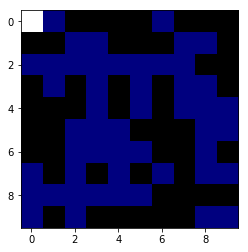

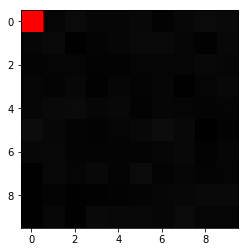

In [123]:
mask = np.zeros((10,10))
#mask[3:-3, 3:-3] = 1 # white square in black background
mask[0,0]=1
im = mask + np.random.randn(10,10) * 0.01 # random image
masked = np.ma.masked_where(mask == 0, mask)
print('mask type is ',type(masked))
print(masked)


empty = np.ma.masked_where(im >0,mask)
print(empty)
print(empty.data)
plt.figure()
plt.imshow(empty.data,cmap='gray')
plt.imshow(empty,cmap='jet')
plt.figure()
plt.imshow(im,cmap='gray')
mmm=mask.astype(np.float)
mmm[np.where(empty.data==0)]=np.nan
plt.imshow(mmm,cmap = 'rainbow',vmin=0,vmax=1)


In [ ]:
data =read_MHA('/media/kgonzalez/Seagate Backup Plus Drive/Heidi/clear_cell_onco/clear_cell/10024-0011_2003-05-19/1.2.840.113619.2.30.1.1762269721.1947.1053353574.617-CT Post-Contrast Nephrographic/1000113604.mha')

print(data.shape)
print('type is ',type(data))
l = np.argwhere(data > 0.5)
print(l)
print(l.shape)
print(l[0][0])
temp=[]
for x in l:
    temp.append(x[0])

nslice = data[25,:,:]
ldata = np.argwhere(nslice> 0.5)
print(ldata)
print('ldata \n',ldata[0])

rowval=[]
colval=[]
for xx in ldata:
    print(xx)
    rowval.append(xx[0])
    colval.append(xx[1])

print('rowval\n',rowval)
print('colval\n',colval)

plt.figure()
plt.imshow(data[27,:,:],cmap='jet')
plt.colorbar()
return
print(image1)
print('type of image1 is ',type(image1))
print(len(ct_type))
print(len(patient_directories))
print('patient directory 0 \n',patient_directories[0])
print('ct_type #0 is ',ct_type[0])
#print(patient_directories[0])
#print(clear_cell_top_dir)
print('type of clear cell dict is ',type(clear_cell_dict))
print('clear cell pt dir type is ',type(clear_cell_top_dir))
print('clear cell pt dir is ------>\n',clear_cell_top_dir)
print(type(clear_cell_dict))
print('clear cell dict is \n',clear_cell_dict)
image_folder =get_folders(clear_cell_top_dir,clear_cell_dict,image1)
print('image_dict ---->\n',image_dict)
print('single image dict\n',image_dict['10024-0011_2003-05-19'])